In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  #use 2080Ti


In [14]:
from keras.applications import VGG16
from keras import models
from keras import layers
from keras.layers.normalization import BatchNormalization


cnn_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

#cnn_base.trainable = False
for layer in cnn_base.layers:
   layer.trainable = False

classify = models.Sequential()
classify.add(BatchNormalization())
classify.add(layers.Flatten())
classify.add(layers.Dense(512, activation='relu'))
classify.add(layers.Dropout(0.5))
classify.add(layers.Dense(10, activation='sigmoid'))


In [15]:
model = models.Sequential()
model.add(cnn_base)
model.add(classify)
cnn_base.summary()
classify.summary()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [16]:
base_dir = 'dataset-diabnext'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range = 30,
        width_shift_range = 0.3,
        height_shift_range = 0.3,
        shear_range = 0.3,
        zoom_range = 0.4,
        channel_shift_range = 0.2,
        fill_mode = 'nearest',
        horizontal_flip = True,
        vertical_flip = False,    
)
test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range = 30,
        width_shift_range = 0.3,
        height_shift_range = 0.3,
        shear_range = 0.3,
        zoom_range = 0.4,
        channel_shift_range = 0.2,
        fill_mode = 'nearest',
        horizontal_flip = True,
        vertical_flip = False,  
)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=10,  
        class_mode='categorical')

Found 1140 images belonging to 10 classes.
Found 370 images belonging to 10 classes.


In [18]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=60,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=60)

Epoch 1/50
 8/60 [===>..........................] - ETA: 13s - loss: 2.5108 - acc: 0.1250

/home/chtseng/envs/AI/lib/python3.6/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


59/60 [============================>.] - ETA: 0s - loss: 2.3725 - acc: 0.1390

/home/chtseng/envs/AI/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


60/60 [==============================] - 23s 389ms/step - loss: 2.3698 - acc: 0.1400 - val_loss: 2.2029 - val_acc: 0.2133
Epoch 2/50
60/60 [==============================] - 21s 351ms/step - loss: 2.3139 - acc: 0.1883 - val_loss: 2.1149 - val_acc: 0.3050
Epoch 3/50
60/60 [==============================] - 21s 347ms/step - loss: 2.1794 - acc: 0.2433 - val_loss: 2.0444 - val_acc: 0.3283
Epoch 4/50
60/60 [==============================] - 21s 350ms/step - loss: 2.1093 - acc: 0.2767 - val_loss: 1.9812 - val_acc: 0.3900
Epoch 5/50
60/60 [==============================] - 21s 351ms/step - loss: 2.0597 - acc: 0.3133 - val_loss: 1.9357 - val_acc: 0.4050
Epoch 6/50
60/60 [==============================] - 21s 348ms/step - loss: 1.9486 - acc: 0.3483 - val_loss: 1.8269 - val_acc: 0.4483
Epoch 7/50
60/60 [==============================] - 21s 352ms/step - loss: 1.8753 - acc: 0.3783 - val_loss: 1.7906 - val_acc: 0.4667
Epoch 8/50
60/60 [==============================] - 21s 350ms/step - loss: 1.836

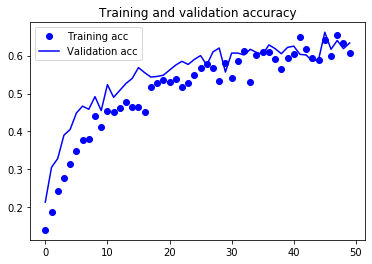

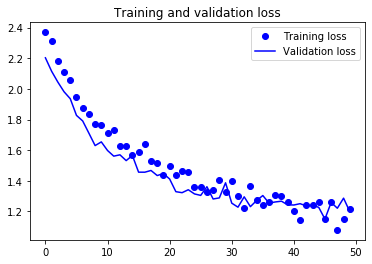

In [20]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
from numba import cuda
cuda.select_device(0)
cuda.close()